### Notebook for the hands on session 2 (Force constant calculation of graphene)

1. **Create a supercell (5x5x1 supercell)**

    ```bash
    > cd 2_force_constant_graphene/work
    > cp ../ref/makedisp_vasp.py .
    > python makedisp_vasp.py
    > less SPOSCAR
    ```


2. **Create an ALM input (ALM0.in) and run**

    ALM0.in has already been created by `makedisp_vasp.py`.

    ```sh
    > alm ALM0.in > ALM0.log
    > grep "Space group" ALM0.log
      Space group: P6/mmm (191) 
    > grep "Number of disp. patterns" ALM0.log
      Number of disp. patterns for  HARMONIC : 4
    ```


3. **Run displace.py to generate displaced configurations**

    We will do this only for the harmonic term. 
    
    The anharmonic terms will be estimated using compressive sensing (CS) approach.
    
    ```sh
    > python -m displace --VASP SPOSCAR --mag 0.01 -pf super551.pattern_HARMONIC --prefix harm
    ```


4. **Run DFT calculation to obtain forces for the displaced configurations** (skipped in this hands on)


5. **Extract displacements and forces from DFT outputs**

    - DFSET for Harmonic
    
    ```sh
    > python -m extract --VASP SPOSCAR ../data/vasprun_harmonic?.xml > DFSET_harmonic
    ```
    <br>
    
    - DFSET for anharmonic 
    
    The files `../data/vasprun_random??.xml` contain DFT calculation results conducted for randomly displaced configurations.

    ```sh
    > python -m extract --VASP SPOSCAR ../data/vasprun_random??.xml > DFSET_random
    ```


6. **Extract harmonic force constants**

    Extract harmonic force constants by setting `NORDER=1`, `MODE = optimize`, and `&optimize` field.

    ```sh
    > cp ALM0.in ALM1.in
    (edit ALM1.in) 
    > alm ALM1.in > ALM1.log
    > grep "Fitting error" ALM1.log
      Fitting error (%) : 1.74943
    ```


7. **Extract anharmonic force constants using compressive sensing approach**

    Let's use `NORDER = 3; NBODY = 2 3 3` and cutoff information of `*-* None 8.1 8.1`, and `PREFIX = graphene_anharm`.
    
    Also, modify the `&optimize` field as follows:
    
    ```
    &optimize
     LMODEL = enet
     NDATA = 20
     DFSET = DFSET_random
     FC2XML = super551.xml # Fix harmonic force constants upon optimization

     CV = 4
     L1_RATIO = 1.0 #LASSO
     CONV_TOL = 1.0e-8
    /
    ```
    
    <br>
    Make input file and run ALM.
    
    ```sh
    > cp ALM1.in CV.in
    (edit CV.in)
    > alm CV.in > CV.log
    ```


    The calculation takes a while (~a few minutes).

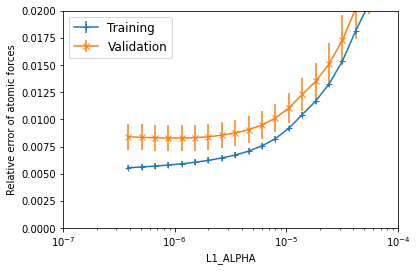

In [15]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('work/graphene_anharm.cvscore')

ax = plt.subplot(111)

ax.errorbar(x=data[:,0],y=data[:,1],yerr=data[:,2],marker='+', label='Training')
ax.errorbar(x=data[:,0],y=data[:,3],yerr=data[:,4],marker='x', label='Validation')
ax.set_xscale('log')
ax.set_xlabel('L1_ALPHA')
ax.set_ylabel('Relative error of atomic forces')

ax.set_ylim(0, 0.02)
ax.set_xlim(1.0e-7, 1.0e-4)
ax.legend(loc='best', fontsize=12)

plt.savefig('cross-validation.pdf', bbox_inches='tight')
plt.show()

8. **Estimate an optimal L1_ALPHA and run optimization**

    The optimal `L1_ALPHA` (L1-regularization parameter) can be estimated as 8.7704e-07.
    
    Now, let's rerun ALM code with the above `L1_ALPHA` value and `CV=0`:
    
    ```
    &optimize
     FC2XML = super551.xml
     DFSET = DFSET_random
     LMODEL = enet
     NDATA = 20
     CV = 0
     L1_ALPHA = 8.7704e-07
    /
    ```
    <br>

    Make input and run ALM
    
    ```
    > cp CV.in opt.in
    (edit opt.in as above)
    > alm opt.in > opt.log
    ```
    
    